In [5]:
# LSTM Autoencoder를 이용한 이상 온도 탐지
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from myProcessData import myProcessData

# 데이터 준비
# temperature.csv 파일에서 데이터 불러오기
all_data = []
data = pd.read_csv('csv/pjh_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/pjh_temperature2.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/jdk_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

data = pd.read_csv('csv/bsb_temperature.csv')
data = data['temperature'].values
data = np.array(data)
data = data[:500]
all_data.append(data)

# # 데이터 전처리 -----------------------------------------------
sequence_length = 20  # 시퀀스 길이 설정
train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[0], sequence_length)

481


In [6]:
# 모델 정의 및 학습 --------------------------------------
# 모델 구성
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()  # Adding ReLU activation function

    def forward(self, x):
        encoded_output = self.relu(self.encoder(x))
        decoded_output = self.relu(self.decoder(encoded_output))
        return decoded_output

# Define model parameters
hidden_size = 16
input_size = 1

# Create an instance of the Autoencoder model
model = Autoencoder(input_size, hidden_size)

# class Autoencoder(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Linear(input_size, hidden_size)
#         self.decoder = nn.Linear(hidden_size, input_size)

#     def forward(self, x):
#         encoded_output = self.encoder(x)
#         decoded_output = self.decoder(encoded_output)
#         return decoded_output

# # 모델 생성
# hidden_size = 16  # 히든 레이어의 크기
# input_size = 1  # 입력 데이터의 차원
# model = Autoencoder(input_size, hidden_size)

# 손실 함수 정의
loss_function = nn.MSELoss()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.001)

# K-fold Cross Validation
k = 4  # Number of folds
fold_losses = []
test_losses = []  # List to store the test losses
result_fold_loss = []
# K-fold data splitting
for i in range(k):
    print(f"Fold {i+1}")
    
    # ===============================================
    # 주요 수정 사항. 
    # 기존에는 데이터 하나를 불러와서 그안에서 80%는 5개의 fold로 쪼개어 학습을 진행하고, 나머지 20%를 테스트용으로 사용했는데,
    # 시계열 특징을 가져야 하는 normal 데이터가 지나치게 잘려나가게 되었음.
    # 직관적으로 설명하자면 기존에는 내 집의 데이터를 연속적으로 학습하지 않고,
    # for문을 돌면서 1번째 fold만 학습한뒤 모델을 "초기화"하고 2번째 fold를 학습한뒤 또다시 모델을 "초기화"한뒤 재차 학습하는것을 반복하였음.
    # 1. 이렇게 학습할 경우 내 집에서의 온도 변화에 대한 패턴 학습이 지속적으로 끊기게 되며, 
    # 2. 기본적으로 fold로 나누게 되면서 각 fold마다 학습되는 데이터의 절대적인 양이 줄어들어 정확도가 많이 떨어질수 밖에 없었다.
    # 이에 기반해서 그냥 각자 4명의 집에서 측정된 데이터를 모두 불러와서
    # 한명의 데이터를 전체 학습시키고, 미리 분리해둔 20%의 테스트 데이터를 해당 모델에 학습시킨 뒤에 모델을 초기화 시켰다.
    train_dataset, train_dataloader, test_subset_dataset = myProcessData(all_data[i], sequence_length)
    train_subset_dataloader = train_dataloader


    # 모델 초기화
    model = Autoencoder(input_size, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    
    # 학습
    fold_loss=[]
    num_epochs = 20  # 학습 횟수 설정
    for epoch in range(num_epochs):
        print(f"epochs: {epoch}")
        for data in train_subset_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_function(outputs.reshape(-1, input_size), data.reshape(-1, input_size))
            loss.backward()
            optimizer.step()
        fold_loss.append(loss.item())

    # 테스트 데이터에 대한 재구성 오차 계산
    with torch.no_grad():
        test_subset_outputs = model(test_subset_dataset)
        test_subset_loss = loss_function(test_subset_outputs, test_subset_dataset)

    # Append the average test loss to test_losses list
    print(f"Loss after training: {fold_loss[-1]}")
    print(f"Fold {i+1} Test loss: {test_subset_loss.item()}")
    print('===========================================================')
    # 수정. 학습결과인 MSE를 기록한다.
    fold_losses.append(fold_loss)
    # 각 fold 별 최종 학습 결과인 MSE를 기록
    result_fold_loss.append(fold_loss[-1])

    # 이건 미리 나눴던 테스트 데이터들을 이용해 예측한 결과인 MSE
    test_losses.append(test_subset_loss.item())

Fold 1
481
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
Loss after training: 0.042550113052129745
Fold 1 Test loss: 0.026697969064116478
Fold 2
481
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
Loss after training: 0.005039450712502003
Fold 2 Test loss: 0.014823493547737598
Fold 3
481
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7
epochs: 8
epochs: 9
epochs: 10
epochs: 11
epochs: 12
epochs: 13
epochs: 14
epochs: 15
epochs: 16
epochs: 17
epochs: 18
epochs: 19
Loss after training: 6.166437378851697e-05
Fold 3 Test loss: 5.2127310482319444e-05
Fold 4
481
epochs: 0
epochs: 1
epochs: 2
epochs: 3
epochs: 4
epochs: 5
epochs: 6
epochs: 7


Training result: [0.042550113052129745, 0.005039450712502003, 6.166437378851697e-05, 0.0005019140662625432]
Each test result: [0.026697969064116478, 0.014823493547737598, 5.2127310482319444e-05, 0.001954583451151848]
Mean threshold: 0.0010


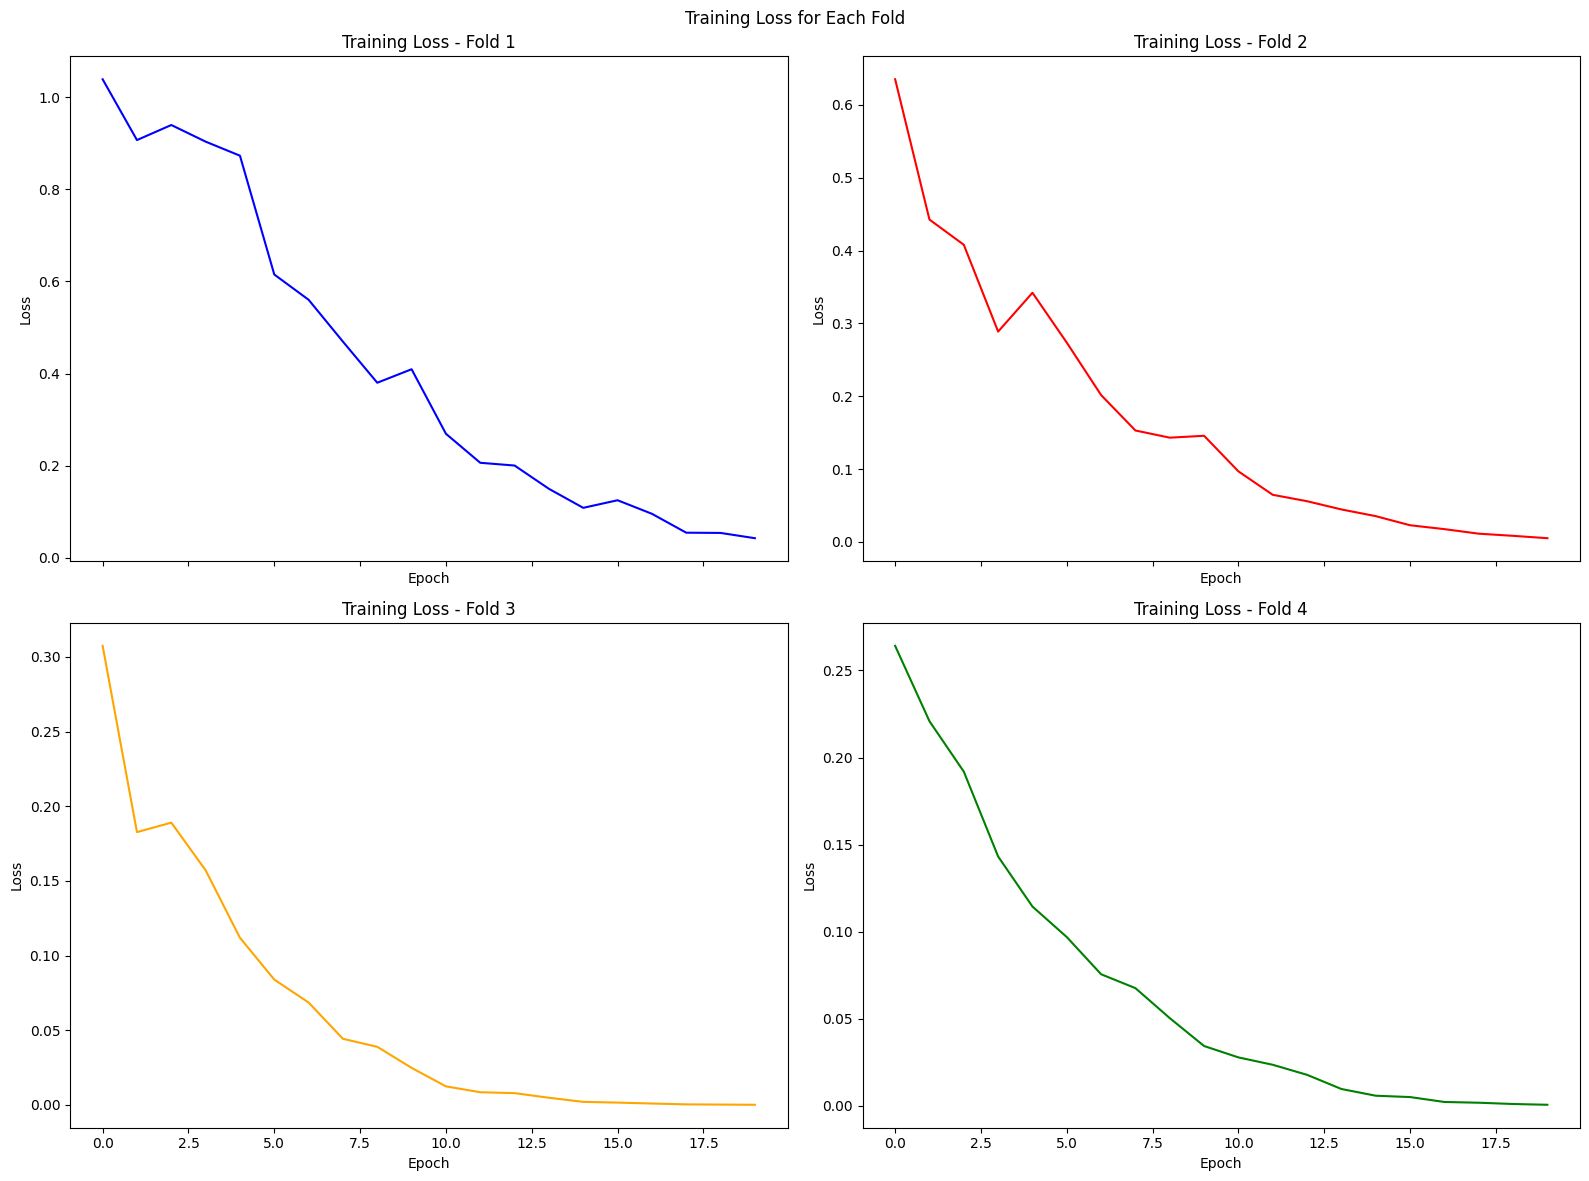

In [7]:
# 최소값과 인접한 값을 클러스터링
# K-means 알고리즘 적용
print(f"Training result: {result_fold_loss}")
print(f"Each test result: {test_losses}")
data = np.array(test_losses).reshape(-1, 1)
k = 2  # 클러스터 개수
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(data)

# 클러스터링 결과 확인
labels = kmeans.labels_
min_value = np.min(test_losses)
min_label = labels[data.flatten() == min_value]
cluster_data = data[labels == min_label]
# Calculate the mean threshold
mean_threshold = np.mean(cluster_data)
print(f"Mean threshold: {mean_threshold:.4f}")



# 테스트 데이터에 대한 이상 감지
# anomaly_indices = torch.where(test_subset_loss > mean_threshold)[0]
# anomaly_data = test_data[anomaly_indices]
# # 이상 감지 결과 출력
# print(f'Anomaly data indices: {anomaly_indices.tolist()}')
# anomaly_data = (anomaly_data * std) + mean
# print(f"Anomaly data: {anomaly_data}")


# Plotting the losses for each fold
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

axes[0, 0].plot(range(len(fold_losses[0])), fold_losses[0], 'b', label="Fold 1")
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss - Fold 1')

axes[0, 1].plot(range(len(fold_losses[1])), fold_losses[1], 'r', label="Fold 2")
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss - Fold 2')

axes[1, 0].plot(range(len(fold_losses[2])), fold_losses[2], 'orange', label="Fold 3")
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Loss - Fold 3')

axes[1, 1].plot(range(len(fold_losses[3])), fold_losses[3], 'g', label="Fold 4")
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss - Fold 4')


plt.suptitle('Training Loss for Each Fold')
plt.tight_layout()
plt.show()

# # 테스트 데이터 - 손실값 
# print(test_data)
# print(test_losses)
# plt.figure(figsize=(10, 6))
# # for i, test_loss in enumerate(test_losses):
# #     plt.plot(range(len(test_loss)), test_loss, label="Test")
# plt.bar(range(len(test_losses)), test_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.grid(True)
# plt.show()

In [8]:
# 비정상 데이터 생성 =======================================
# 데이터 파일 불러오기
data = pd.read_csv('csv/bsb_temperature.csv')
abnormal_data = data['temperature'].values
abnormal_data = abnormal_data[:500]

# Noise case 1 : 정현파 노이즈
X=np.linspace(0,4*np.pi,len(abnormal_data))
sin_wave=np.sin(X)
abnormal_data += sin_wave

# Noise case 2 : 특정 구간 랜덤 노이즈
start_index = 200
end_index = 400
interval_length = end_index - start_index
noise = np.random.normal(0, 0.5, interval_length)
abnormal_data[start_index:end_index] += noise

# Normalization
abnormal_mean = np.mean(abnormal_data)
abnormal_std = np.std(abnormal_data)
abnormal_data = (abnormal_data - abnormal_mean) / abnormal_std

# 데이터를 시계열 시퀀스로 변환
abnormal_sequence = []
for i in range(len(abnormal_data) - sequence_length + 1):
    sequence = abnormal_data[i:i+sequence_length]
    abnormal_sequence.append(sequence)
# PyTorch 데이터셋 생성
abnormal_dataset = torch.Tensor(abnormal_sequence)
# 2D로 변환
abnormal_dataset = np.reshape(abnormal_dataset, (-1, sequence_length, input_size))



# 비정상 데이터에 대한 재구성 오차 계산
with torch.no_grad():
    abnormal_outputs = model(abnormal_dataset)
    abnormal_loss = loss_function(abnormal_outputs, abnormal_dataset)
print(f'Abnormal data loss: {abnormal_loss.item():.4f}')

# ===============================================

Abnormal data loss: 0.0008
